# Análise Comparativa: Players × Estratégias de Busca

## Vamos rodar Monte Carlo para cada par (Player, Search) e comparar as métricas.

## 1. Cabeçalho e configurações iniciais

In [1]:
%matplotlib inline
import random
import pandas as pd
import matplotlib.pyplot as plt

from main import rodar_simulacao
from search import (
    GreedySearch, 
    DijkstraSearch, 
    AStarSearch, 
    WeightedAStarSearch
)
from player import (
    DefaultPlayer,    
    DoubleBatchPlayer,
    FullBatchPlayer,     
    AdaptivePlayer,
    ClusterAdaptivePlayer,
    RechargerPlayer,
    OptimalPlayer,
    OptimalRechargerPlayer
)

pygame 2.6.1 (SDL 2.28.4, Python 3.13.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


## 2. Definição de listas de players e buscas

In [2]:
SEARCH_ALGORITHMS = [    
    GreedySearch,
    DijkstraSearch,
    AStarSearch,
    WeightedAStarSearch,
]

PLAYERS = [
    DefaultPlayer,    
    DoubleBatchPlayer,
    FullBatchPlayer,
    AdaptivePlayer,
    ClusterAdaptivePlayer,
    RechargerPlayer,
    OptimalPlayer,
    OptimalRechargerPlayer,
]

## 3. Funções de Monte Carlo e sumarização

In [3]:
def monte_carlo(player_cls, search_cls, seeds):
    """
    Executa n simulações Monte Carlo para um par (player, search).
    Retorna uma lista de dicionários com os resultados.
    """
    results = []
    for seed in seeds:
        r = rodar_simulacao(seed, player_cls, search_cls)
        r["player"] = player_cls.__name__
        r["search"] = search_cls.__name__
        r["seed"]   = seed
        results.append(r)
    return results

def summarize(df: pd.DataFrame) -> pd.DataFrame:
    """
    Agrupa por (player, search) e calcula estatísticas:
    passos, score, entregas, bateria, percentuais, tempo em ms.
    """
    summary = (
        df.groupby(["player","search"])
        .agg(
            mean_steps      = ("passos",  "mean"),
            std_steps       = ("passos",  "std"),
            mean_score      = ("score",   "mean"),
            std_score       = ("score",   "std"),
            mean_deliveries = ("entregas","mean"),
            std_deliveries  = ("entregas","std"),
            mean_battery    = ("bateria", "mean"),
            std_battery     = ("bateria", "std"),
            pct_score_neg   = ("score",   lambda s: (s < 0).mean() * 100),
            pct_batt_neg    = ("negative_battery_count", lambda s: (s > 0).mean() * 100),
            mean_search_ms  = ("avg_search_time", lambda s: s.mean() * 1000),
            std_search_ms   = ("avg_search_time", lambda s: s.std() * 1000),
            mean_time_ms    = ("sim_time", lambda s: s.mean() * 1000),
            std_time_ms     = ("sim_time", lambda s: s.std() * 1000),
        )
        .round(2)
        .reset_index()
    )
    return summary

## 4. Funções de plotagem

In [4]:
def plot_metric(df, metric, title, ylabel):
    """
    Plota um barplot comparativo do metric para cada player,
    com barras coloridas por estratégia de busca.
    """
    pivot = df.pivot(index="player", columns="search", values=metric)
    ax = pivot.plot(kind="bar", figsize=(8,4))
    ax.set_title(title)
    ax.set_xlabel("Player")
    ax.set_ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.legend(title="Busca")
    plt.tight_layout()
    plt.show()

def plot_all(summary):
    """
    Gera um gráfico para cada métrica de interesse.
    """
    plot_metric(summary, "mean_steps",      "Passos Médios",                  "Passos Médios")
    plot_metric(summary, "mean_score",      "Score Médio",                    "Pontos Médios")
    plot_metric(summary, "mean_deliveries", "Entregas Médias",                "Entregas Médias")
    plot_metric(summary, "mean_battery",    "Bateria Média",                  "Carga Média Restante")
    plot_metric(summary, "pct_score_neg",   "% Scores Negativos",             "% Simulações Score < 0")
    plot_metric(summary, "pct_batt_neg",    "% Baterias Negativas",           "% Simulações Bateria Negativa")
    plot_metric(summary, "mean_search_ms",  "Tempo Médio de Busca (ms)",      "ms por Busca")
    plot_metric(summary, "mean_time_ms",    "Tempo Médio por Simulação (ms)", "ms por Simulação")

## 5. Geração de seeds e execução Monte Carlo

In [5]:
# 1) Seeds fixas para reprodutibilidade
num_sim = 300
random.seed(42)
seeds = [random.randint(0, 100_000) for _ in range(num_sim)]

# 2) Executa Monte Carlo
all_results = []
for player in PLAYERS:
    for search in SEARCH_ALGORITHMS:
        print(f"Executando Monte Carlo para --- {player.__name__} + {search.__name__}")
        all_results.extend(monte_carlo(player, search, seeds))

# 3) Converte para DataFrame
df = pd.DataFrame(all_results)

Executando Monte Carlo para --- DefaultPlayer + GreedySearch
Executando Monte Carlo para --- DefaultPlayer + DijkstraSearch
Executando Monte Carlo para --- DefaultPlayer + AStarSearch
Executando Monte Carlo para --- DefaultPlayer + WeightedAStarSearch
Executando Monte Carlo para --- DoubleBatchPlayer + GreedySearch
Executando Monte Carlo para --- DoubleBatchPlayer + DijkstraSearch
Executando Monte Carlo para --- DoubleBatchPlayer + AStarSearch
Executando Monte Carlo para --- DoubleBatchPlayer + WeightedAStarSearch
Executando Monte Carlo para --- FullBatchPlayer + GreedySearch
Executando Monte Carlo para --- FullBatchPlayer + DijkstraSearch
Executando Monte Carlo para --- FullBatchPlayer + AStarSearch
Executando Monte Carlo para --- FullBatchPlayer + WeightedAStarSearch
Executando Monte Carlo para --- AdaptivePlayer + GreedySearch
Executando Monte Carlo para --- AdaptivePlayer + DijkstraSearch
Executando Monte Carlo para --- AdaptivePlayer + AStarSearch
Executando Monte Carlo para --- A

## 6. Sumarização e exibição

In [6]:
# Carregamento dos dados opcional para caso não queira executar a simulação
# summary = pd.read_csv("player_search_comparison.csv")
summary = summarize(df)
display(summary)

,player,search,mean_steps,std_steps,mean_score,std_score,mean_deliveries,std_deliveries,mean_battery,std_battery,pct_score_neg,pct_batt_neg,mean_search_ms,std_search_ms,mean_time_ms,std_time_ms
0,AdaptivePlayer,AStarSearch,104.20,19.84,22.83,60.43,3.99,0.08,-32.75,24.55,35.67,93.00,0.13,0.06,11.98,3.91
1,AdaptivePlayer,DijkstraSearch,104.24,19.82,22.89,60.25,3.99,0.08,-32.32,25.09,35.67,93.33,0.60,0.14,16.02,4.09
2,AdaptivePlayer,GreedySearch,108.15,21.59,-13.54,74.29,3.99,0.08,-42.49,31.53,57.33,95.33,0.05,0.02,11.24,3.62
3,AdaptivePlayer,WeightedAStarSearch,104.72,20.13,17.25,62.76,3.99,0.08,-33.58,26.35,40.00,94.00,0.08,0.03,11.44,3.64
4,ClusterAdaptivePlayer,AStarSearch,104.78,20.25,21.20,61.71,3.99,0.08,-33.32,24.89,35.67,93.33,0.13,0.06,58.03,16.45
5,ClusterAdaptivePlayer,DijkstraSearch,104.82,20.23,21.11,61.55,3.99,0.08,-32.91,25.64,35.67,93.67,0.61,0.15,62.15,16.58
6,ClusterAdaptivePlayer,GreedySearch,108.91,22.26,-15.25,77.00,3.99,0.08,-43.04,32.06,56.00,95.00,0.06,0.02,57.53,16.35
7,ClusterAdaptivePlayer,WeightedAStarSearch,105.35,20.64,15.49,64.46,3.99,0.08,-34.20,26.73,38.67,94.33,0.08,0.04,57.69,16.46
8,DefaultPlayer,AStarSearch,117.00,27.93,-11.17,80.58,3.98,0.29,-38.81,36.69,50.33,93.67,0.19,0.11,1.65,0.65
9,DefaultPlayer,DijkstraSearch,117.10,27.97,-10.72,80.77,3.98,0.29,-38.39,36.96,49.67,93.67,0.85,0.25,7.01,2.03


## 7. Salvando CSV

In [7]:
summary.to_csv("player_search_comparison.csv", index=False)
print("Resumo salvo em player_search_comparison.csv")

Resumo salvo em player_search_comparison.csv


## 8. Plots finais

### 8.1. Gráficos de barra

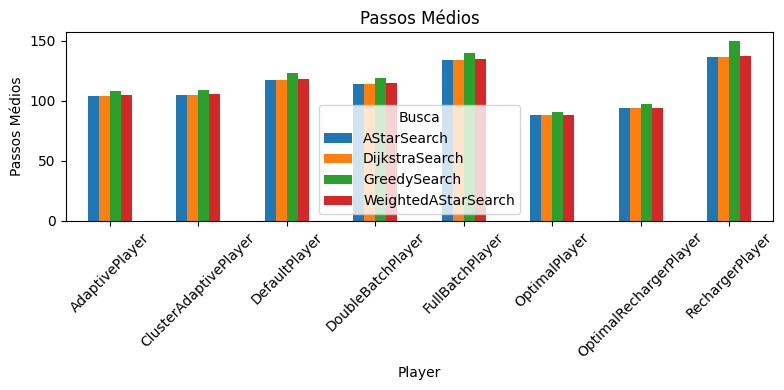

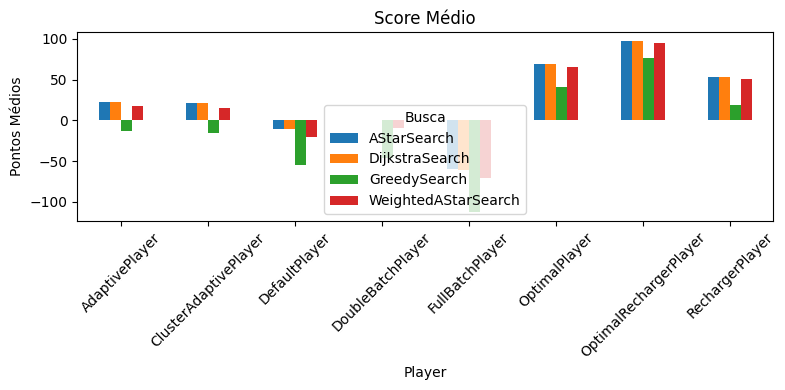

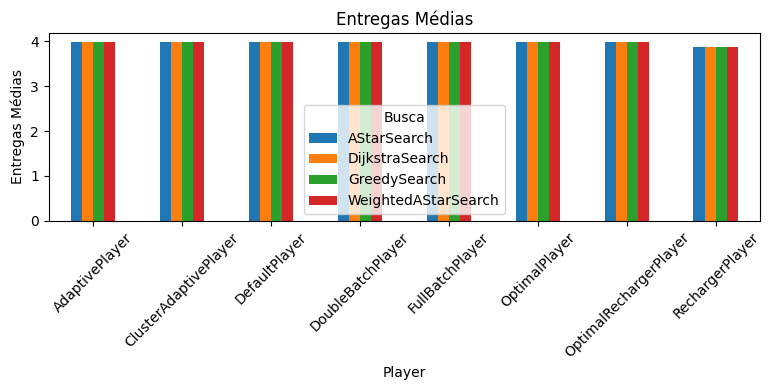

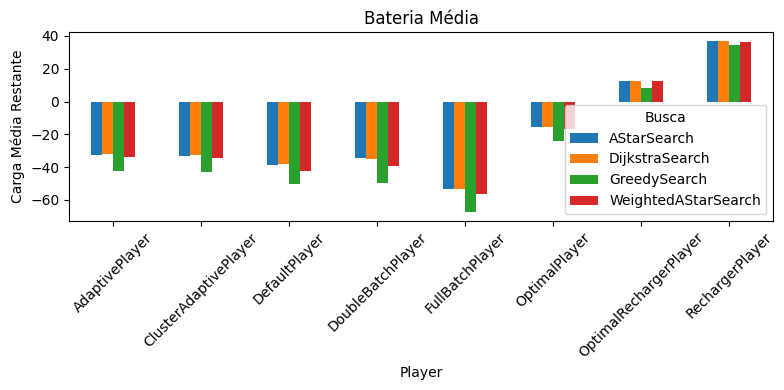

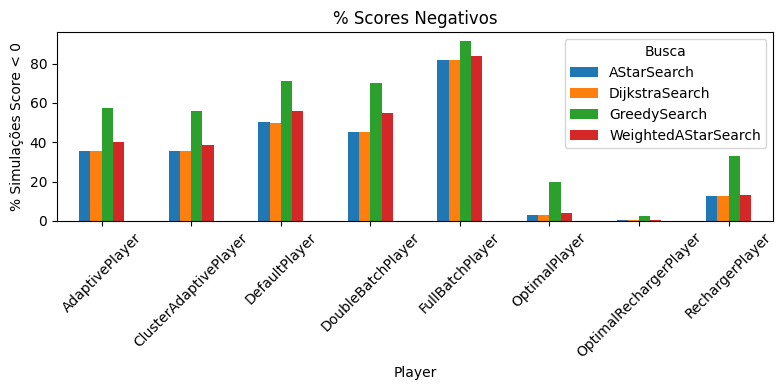

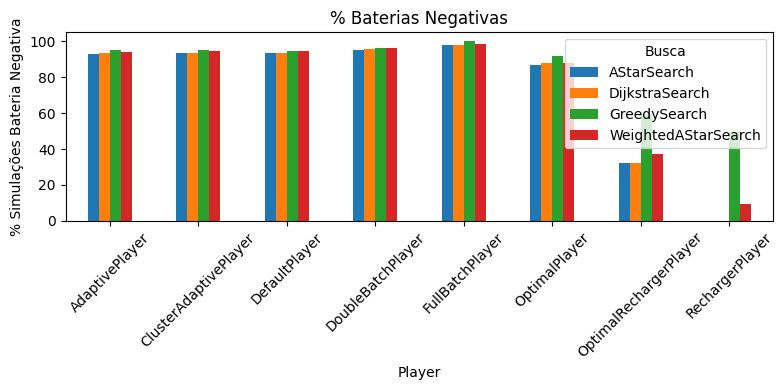

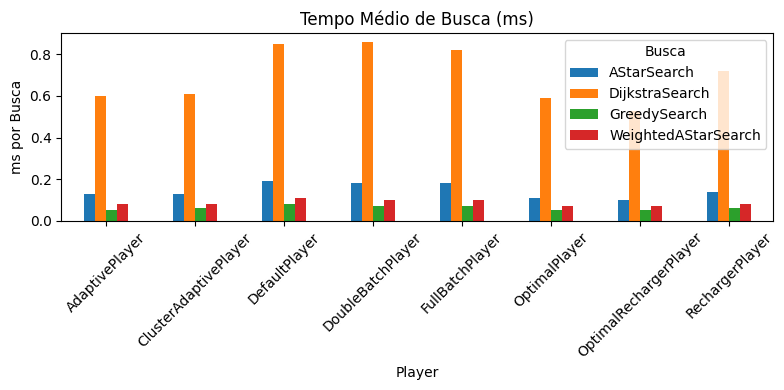

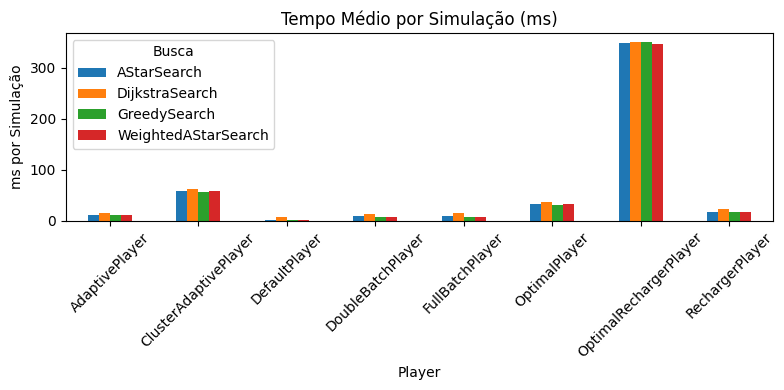

In [11]:
plot_all(summary)

### 8.2. Gráficos boxplot

C:\Users\Washington\AppData\Local\Temp\ipykernel_14364\2091921476.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


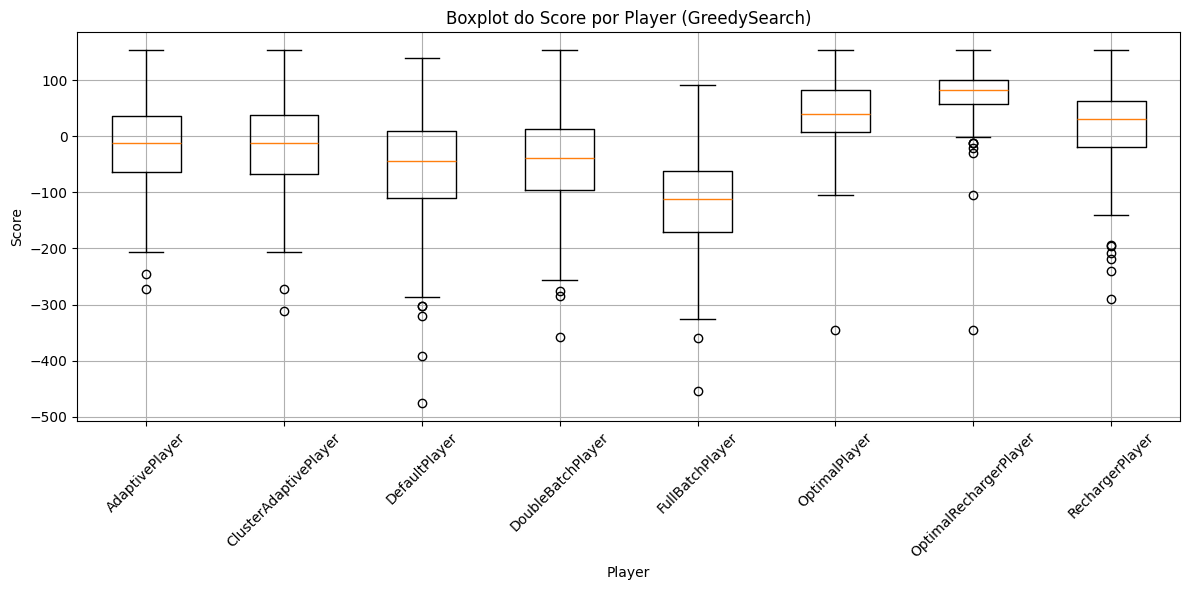

C:\Users\Washington\AppData\Local\Temp\ipykernel_14364\2091921476.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


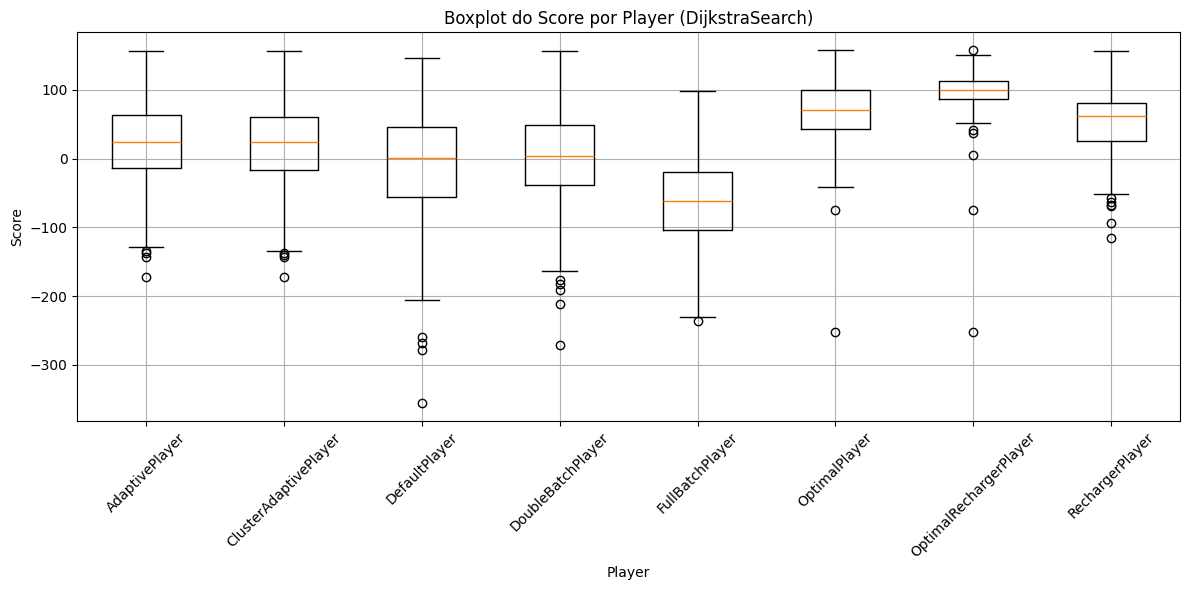

C:\Users\Washington\AppData\Local\Temp\ipykernel_14364\2091921476.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


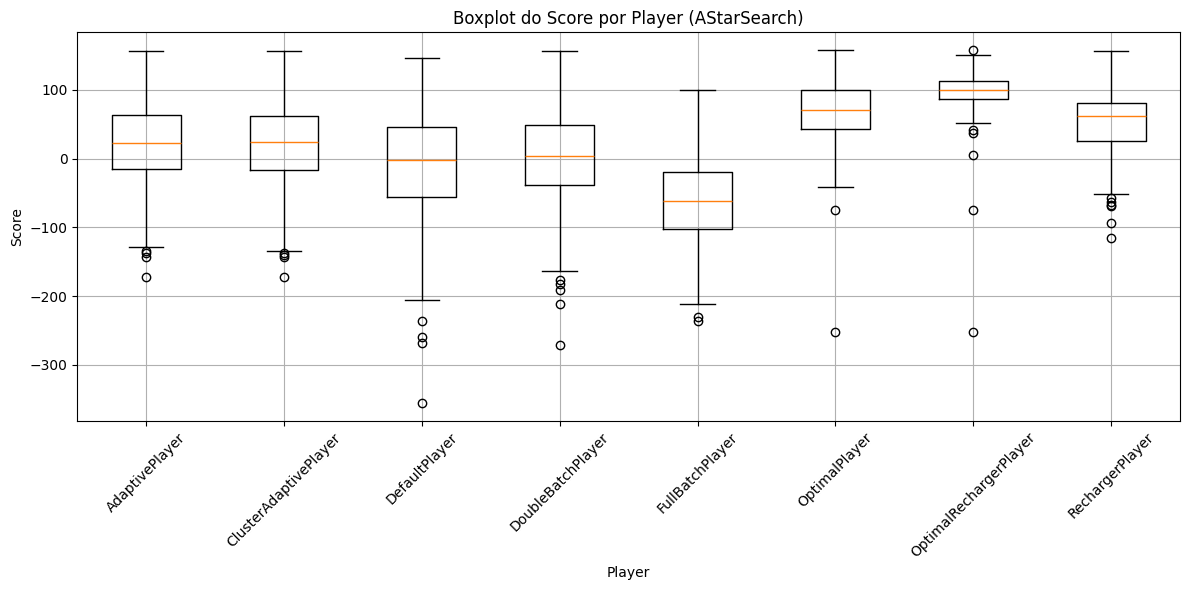

C:\Users\Washington\AppData\Local\Temp\ipykernel_14364\2091921476.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


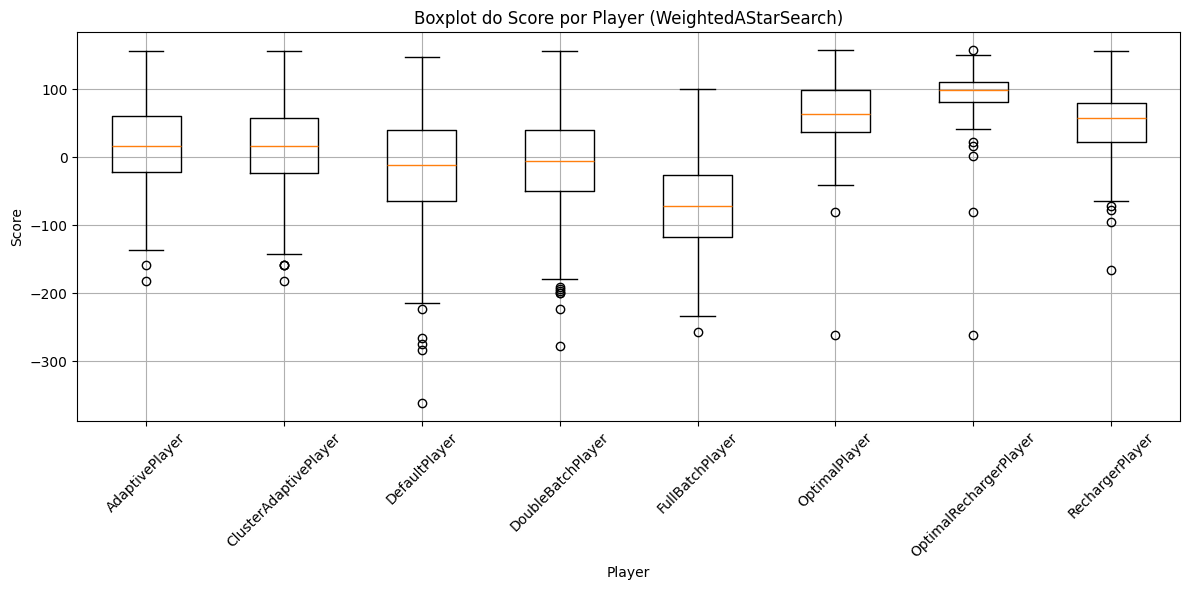

In [10]:
for search_name in [alg.__name__ for alg in SEARCH_ALGORITHMS]:
    players_sorted = sorted(df["player"].unique())
    df_search = df[df["search"] == search_name]
    plt.figure(figsize=(12, 6))
    plt.boxplot(
        [df_search[df_search["player"] == player]["score"] for player in players_sorted],
        labels=players_sorted
    )
    plt.title(f"Boxplot do Score por Player ({search_name})")
    plt.xlabel("Player")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()
